In [145]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import SVC
from string import punctuation
from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_t

True

In [7]:
df = pd.read_csv('./data/sampled_data.csv')
df.head()

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,3253,thanks..... .................................,4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,184464874,29,2100844,https://www.tokopedia.com/miniperkakas/rexco-1...
1,3559,oke barang sudah di terima dengan baik...,4,elektronik,Alfalink EI 428 - Kamus Elektronik Electronic ...,24896339,283,588756,https://www.tokopedia.com/omegaelectronic/alfa...
2,3131,"brg udh dtg #pontianak dgn slmat gan, mksih..",5,elektronik,Alfalink EI 212 - Kamus Elektronik,20602038,383,588756,https://www.tokopedia.com/omegaelectronic/alfa...
3,3658,Cepat dan tepat! Recommended seller,5,elektronik,TI-84 Plus CE,38187136,53,844505,https://www.tokopedia.com/datasempoa/ti-84-plu...
4,3252,"mantaf,. langsung test.. residu hilang\nkirima...",4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,184464874,29,2100844,https://www.tokopedia.com/miniperkakas/rexco-1...


In [8]:
print(df['category'].value_counts())

category
elektronik     1000
fashion        1000
olahraga       1000
handphone      1000
pertukangan    1000
Name: count, dtype: int64


# Pre-Processing

In [9]:
df = df.drop(columns=['Unnamed: 0', 'product_id', 'shop_id', 'sold', 'product_url'])
df

,text,rating,category,product_name
0,thanks..... .................................,4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...
1,oke barang sudah di terima dengan baik...,4,elektronik,Alfalink EI 428 - Kamus Elektronik Electronic ...
2,"brg udh dtg #pontianak dgn slmat gan, mksih..",5,elektronik,Alfalink EI 212 - Kamus Elektronik
3,Cepat dan tepat! Recommended seller,5,elektronik,TI-84 Plus CE
4,"mantaf,. langsung test.. residu hilang\nkirima...",4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...
...,...,...,...,...
4995,Trims gan paket telah di terima .,4,pertukangan,Staples Gun Tacker Mollar 3 in 1 / Staple Jok ...
4996,terimakasih pengiriman cepat.....................,5,pertukangan,staples tembak HOMASTER / steples tembak / sta...
4997,terima kasih n maaf baru konfirmasi..,5,pertukangan,staples tembak homaster / staple gun
4998,Terima kasih packing rapi,4,pertukangan,staples tembak staple gun tacker staples jok m...


In [13]:
slang_df = pd.read_csv("./data/slang_dict.csv", sep=';')
slang_dict = pd.Series(slang_df['baku'].values, index=slang_df['slang'].values).to_dict()

def replace_slang(text, slang_dict):
    words = word_tokenize(text)  
    new_text = ' '.join([slang_dict[word] if word in slang_dict else word for word in words])
    return new_text

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\&\w*;", "", text)  # Menghapus HTML entities
    text = re.sub(r"@[^\s]+", "", text)  # Menghapus mention @
    text = re.sub(r"\$\w*", "", text)  # Menghapus simbol uang
    text = re.sub(r"https?:\/\/.*\/\w*", "", text)  # Menghapus URL
    text = re.sub(r"#\w*", "", text)  # Menghapus hashtag
    text = re.sub(r"\b\w{1,2}\b", "", text)  # Menghapus kata pendek
    text = re.sub(r"\s+", " ", text).strip()  # Normalisasi spasi
    text = "".join(c for c in text if c <= "\uFFFF")  # Menghapus karakter tidak valid
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"") # menghapus tab, new line, ans back slice
    text = text.encode('ascii', 'replace').decode('ascii') # menghapus non ASCII (emoticon, chinese word, .etc)
    text = re.sub(r"\d+", " ", text) # menghapus number
    text = text.translate(str.maketrans("","",string.punctuation)) # menghapus punctuation
    text = replace_slang(text, slang_dict) # Penggantian slang

    # Penghapusan stopwords
    stop_words = set(stopwords.words('indonesian'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)
data = df.drop_duplicates(subset='cleaned_text')
df


,text,rating,category,product_name,cleaned_text
0,thanks..... .................................,4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,thanks
1,oke barang sudah di terima dengan baik...,4,elektronik,Alfalink EI 428 - Kamus Elektronik Electronic ...,oke barang terima
2,"brg udh dtg #pontianak dgn slmat gan, mksih..",5,elektronik,Alfalink EI 212 - Kamus Elektronik,barang selamat kawan terimakasih
3,Cepat dan tepat! Recommended seller,5,elektronik,TI-84 Plus CE,cepat rekomendasi seller
4,"mantaf,. langsung test.. residu hilang\nkirima...",4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,mantap langsung test residu hilang kirim lamba...
...,...,...,...,...,...
4995,Trims gan paket telah di terima .,4,pertukangan,Staples Gun Tacker Mollar 3 in 1 / Staple Jok ...,terimakasih kawan paket terima
4996,terimakasih pengiriman cepat.....................,5,pertukangan,staples tembak HOMASTER / steples tembak / sta...,terimakasih kirim cepatdan barang sesuai
4997,terima kasih n maaf baru konfirmasi..,5,pertukangan,staples tembak homaster / staple gun,terima kasih maaf konfirmasi
4998,Terima kasih packing rapi,4,pertukangan,staples tembak staple gun tacker staples jok m...,terima kasih packing rapi


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          5000 non-null   object
 1   rating        5000 non-null   int64 
 2   category      5000 non-null   object
 3   product_name  5000 non-null   object
 4   cleaned_text  4952 non-null   object
 5   label         5000 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [48]:
# Cek baris yang memiliki NaN di cleaned_text
nan_rows = df[df['cleaned_text'].isna()]
print(nan_rows[['text', 'cleaned_text']])

                                                   text cleaned_text
376      **********************************************          NaN
440   ok...............................................          NaN
482                           *************************          NaN
526    ....................;) ::) :)...................          NaN
981   .................................................          NaN
1061                     cukup baik....................          NaN
1108                  .................................          NaN
1165                   👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍          NaN
1548                          Ada 1 bagian yg tidak ada          NaN
1559                                         👍👍👍👍👍👍👍👍👍👍          NaN
1687                        ok...…………………………………………………...          NaN
1767                             ......................          NaN
1799                            ok...........,.,.......          NaN
1842  ............................

In [50]:
df = df.dropna(subset=['cleaned_text'])
df.isnull().sum()

text            0
rating          0
category        0
product_name    0
cleaned_text    0
label           0
dtype: int64

# Klasifikasi Sentimen

Pelabelan Manual

In [78]:
positive_words = ["gak kecewa", "super", "sip", "cepat", "suka", "mantab", "worth", "awet", "mantul", "selamat", "good", "recomended", "tebal", "semangat", "rekomendasi", "kuat", "thank you", "makasih", "aman", "rapi", "fast", "thanks", "barang", "sesuai", "cepae", "bagus", "selamat", "sudah", "sampai", "terima", "excellent", "baik", "mantap", "puas", "terima kasih", "keren" "original", "percaya", "awesomee", "terimakasih", "thank you", "murah", "recommended", "aman", "pas", "bersih", "original", "rapi", "mulus", "ramah", "cocok", "nyaman", "terpercaya", "top", "sip", "oke"]
negative_words = ["gagal", "cacat", "tidak", "kurang", "rusak", "salah", "lama", "terlambat", "jelek", "cacat", "kecewa", "penipuan", "palsu", "buruk", "lelet", "kotor", "hancur", "lambat", "menyesal", "tidak sesuai", "bohong", "residu", "disayangkan", "trouble", "mengecewakan"]

def label_sentiment(text):
    if isinstance(text, str):
        pos_count = sum(1 for word in positive_words if word in text)
        neg_count = sum(1 for word in negative_words if word in text)
        
        if pos_count > neg_count:
            return 'positive'
        elif neg_count > pos_count:
            return 'negative'
        else:
            return 'neutral'
    else:
        return 'neutral'  

df['label'] = df['cleaned_text'].apply(label_sentiment)
df.sample(5)

,text,rating,category,product_name,cleaned_text,label
3299,biarkan bintang yg berbicara,5,handphone,Xiaomi Redmi Note 4 &#40; Pro / 4X &#41; Snapd...,biar bintang bicara,neutral
4883,Barang bagus sesuai pesanan,5,pertukangan,Staples Gun Tacker Mollar 3 in 1 / Staple Jok ...,barang bagus sesuai pesan,positive
4885,pas dengan yang saya cari ... barang bagus,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gun,pas cari barang bagus,positive
1809,"Barang bagus kokoh,, semoga awet",5,fashion,X04 Rak sepatu 4 SUSUN payung holder lemari se...,barang bagus kokoh moga awet,positive
3035,Kualitas buruk. Ada harga Ada kualitas,2,handphone,&#40;EH138&#41; Kacamata Dial Vision Bebas Atu...,kualitas buruk harga kualitas,negative


In [79]:
sentiment_counts = df['label'].value_counts()
print(sentiment_counts)

label
positive    4416
neutral      491
negative      45
Name: count, dtype: int64


Menyimpan Data

In [54]:
df.to_excel('data_cleaned.xlsx', index=False)

Membaca Data Hasil Pre-Processing

In [187]:
df = pd.read_excel('data_cleaned.xlsx')

Memisahkan Fitur dan Target

In [188]:
X = df['cleaned_text'] 
y = df['label']

TF-IDF Vectorization

In [189]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

Split Data

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Pemodelan

Model Naive Bayes

In [191]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

print('--------------------- Confusion Matrix  ----------------------------')
print(confusion_matrix(y_test, y_pred_nb))

print('--------------------- Classification Report  ----------------------------')
print(classification_report(y_test, y_pred_nb))

--------------------- Confusion Matrix  ----------------------------
[[  0   0   9]
 [  0   6  92]
 [  0   0 884]]
--------------------- Classification Report  ----------------------------
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         9
     neutral       1.00      0.06      0.12        98
    positive       0.90      1.00      0.95       884

    accuracy                           0.90       991
   macro avg       0.63      0.35      0.35       991
weighted avg       0.90      0.90      0.86       991



c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Model Support Vector Machine (SVM)

In [192]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

print('--------------------- Confusion Matrix  ----------------------------')
print(confusion_matrix(y_test, y_pred_svm))

print('--------------------- Classification Report  ----------------------------')
print(classification_report(y_test, y_pred_svm))

--------------------- Confusion Matrix  ----------------------------
[[  0   8   1]
 [  0  24  74]
 [  0   2 882]]
--------------------- Classification Report  ----------------------------
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         9
     neutral       0.71      0.24      0.36        98
    positive       0.92      1.00      0.96       884

    accuracy                           0.91       991
   macro avg       0.54      0.41      0.44       991
weighted avg       0.89      0.91      0.89       991



c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Model Random Forest

In [193]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print('--------------------- Confusion Matrix  ----------------------------')
print(confusion_matrix(y_test, y_pred_rf))

print('--------------------- Classification Report  ----------------------------')
print(classification_report(y_test, y_pred_rf))

--------------------- Confusion Matrix  ----------------------------
[[  5   2   2]
 [  0  20  78]
 [  0   6 878]]
--------------------- Classification Report  ----------------------------
              precision    recall  f1-score   support

    negative       1.00      0.56      0.71         9
     neutral       0.71      0.20      0.32        98
    positive       0.92      0.99      0.95       884

    accuracy                           0.91       991
   macro avg       0.88      0.58      0.66       991
weighted avg       0.90      0.91      0.89       991



Model Regresi Logistik

In [194]:
model_logistic = LogisticRegression(random_state=42)
model_logistic.fit(X_train, y_train)
y_pred_logistic = model_logistic.predict(X_test)

print('--------------------- Confusion Matrix  ----------------------------')
print(confusion_matrix(y_test, y_pred_logistic))

print('--------------------- Classification Report  ----------------------------')
print(classification_report(y_test, y_pred_logistic))

--------------------- Confusion Matrix  ----------------------------
[[  0   6   3]
 [  0  18  80]
 [  0   3 881]]
--------------------- Classification Report  ----------------------------
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         9
     neutral       0.67      0.18      0.29        98
    positive       0.91      1.00      0.95       884

    accuracy                           0.91       991
   macro avg       0.53      0.39      0.41       991
weighted avg       0.88      0.91      0.88       991



c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Model Decision Tree

In [195]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

print('--------------------- Confusion Matrix  ----------------------------')
print(confusion_matrix(y_test, y_pred_tree))

print('--------------------- Classification Report  ----------------------------')
print(classification_report(y_test, y_pred_tree))

--------------------- Confusion Matrix  ----------------------------
[[  5   4   0]
 [  0  84  14]
 [  0  36 848]]
--------------------- Classification Report  ----------------------------
              precision    recall  f1-score   support

    negative       1.00      0.56      0.71         9
     neutral       0.68      0.86      0.76        98
    positive       0.98      0.96      0.97       884

    accuracy                           0.95       991
   macro avg       0.89      0.79      0.81       991
weighted avg       0.95      0.95      0.95       991



Validasi Silang (Cross-Validation)

In [201]:
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

for name, model in models.items():
    score = cross_val_score(model, X_tfidf, y, cv=5, scoring='accuracy')  
    print(f"{name} Cross-validation scores: {score}")
    print(f"{name} Mean Cross-validation score: {score.mean():.2f}\n")

Naive Bayes Cross-validation scores: [0.89707366 0.8950555  0.89494949 0.89292929 0.8979798 ]
Naive Bayes Mean Cross-validation score: 0.90

SVM Cross-validation scores: [0.89808274 0.89909183 0.9        0.89494949 0.90505051]
SVM Mean Cross-validation score: 0.90

Logistic Regression Cross-validation scores: [0.90211907 0.90413724 0.90606061 0.9010101  0.90606061]
Logistic Regression Mean Cross-validation score: 0.90

Random Forest Cross-validation scores: [0.91321897 0.90918264 0.90606061 0.91010101 0.91414141]
Random Forest Mean Cross-validation score: 0.91

Decision Tree Cross-validation scores: [0.95459132 0.92230071 0.93030303 0.93939394 0.93939394]
Decision Tree Mean Cross-validation score: 0.94



Memisahkan Review Positif dan Negatif

In [72]:
positive = df[df['label'] == 'positive']
negative = df[df['label'] == 'negative']
neutral = df[df['label'] == 'neutral']

Menggabungkan Teks Review Positif dan Negatif

In [73]:
positive_text = ' '.join(positive['cleaned_text'])
negative_text = ' '.join(negative['cleaned_text'])
neutral_text = ' '.join(neutral['cleaned_text'])

In [74]:
positive_reviews = pd.DataFrame({'Review': positive['cleaned_text'], 'Sentiment': 'Positive'})
negative_reviews = pd.DataFrame({'Review': negative['cleaned_text'], 'Sentiment': 'Negative'})
neutral_reviews = pd.DataFrame({'Review': neutral['cleaned_text'], 'Sentiment': 'Neutral'})

In [75]:
positive_reviews

,Review,Sentiment
0,thanks,Positive
1,oke barang terima,Positive
2,barang selamat kawan terimakasih,Positive
3,cepat rekomendasi seller,Positive
5,barang cepst sampe paking bsgus,Positive
...,...,...
4947,terimakasih kawan paket terima,Positive
4948,terimakasih kirim cepatdan barang sesuai,Positive
4949,terima kasih maaf konfirmasi,Positive
4950,terima kasih packing rapi,Positive


In [81]:
negative_reviews.sample(7)

,Review,Sentiment
1454,kecewa sistem kerja kirim jasa kirim nya sedia...,Negative
1165,kirim proses lamaaaa,Negative
2272,produk jual kurir masalah,Negative
3493,buruk pdahal situ pengirimanya hari nyampenya ...,Negative
3129,parahjelek bngt speaker gak org nelp gak kdgra...,Negative
1087,kotak rusak lem sepatu bngt,Negative
1549,mengecwakan pesan sepatu kirim sepatu dintelfo...,Negative


In [77]:
neutral_reviews

,Review,Sentiment
13,bagus produk sayang system kirim send trouble ...,Neutral
15,alfalinknya kecilimut,Neutral
22,danke kawan,Neutral
26,yaah harga ribu lumayan laah jangkau mudah an ...,Neutral
35,biar bintang bicara,Neutral
...,...,...
4870,okkkkkkkkkkkkkkkkkkk,Neutral
4889,nyampe jam transaksiudah nyampe rumahmksh,Neutral
4897,biar bintang bicarathank,Neutral
4899,masang jok gak pake,Neutral


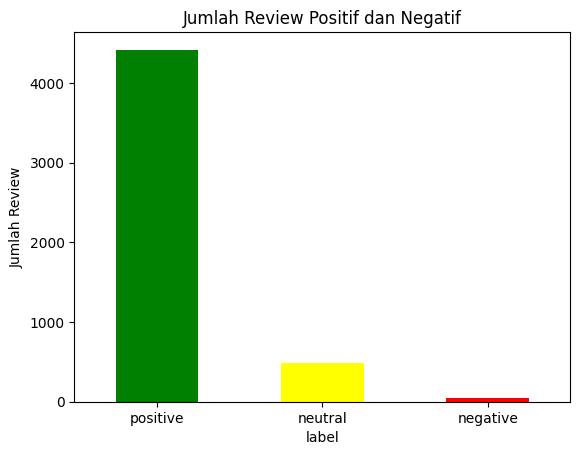

In [82]:
sentiment_counts = df['label'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Jumlah Review Positif dan Negatif')
plt.xlabel('label')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=0)
plt.show()


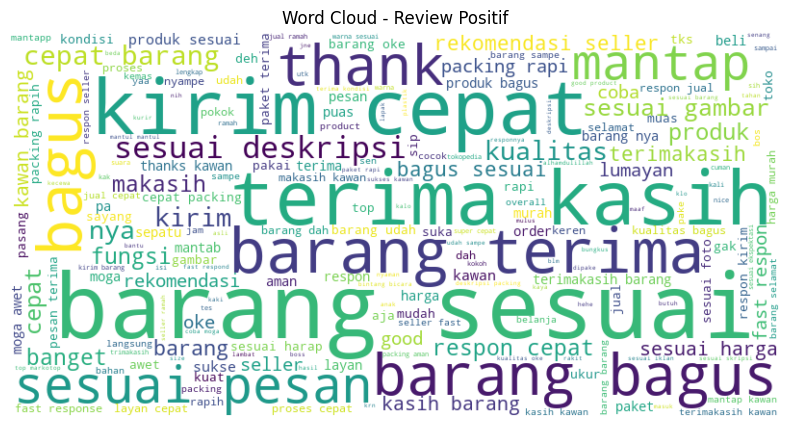

In [83]:
# Word Cloud untuk review positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Review Positif')
plt.show()

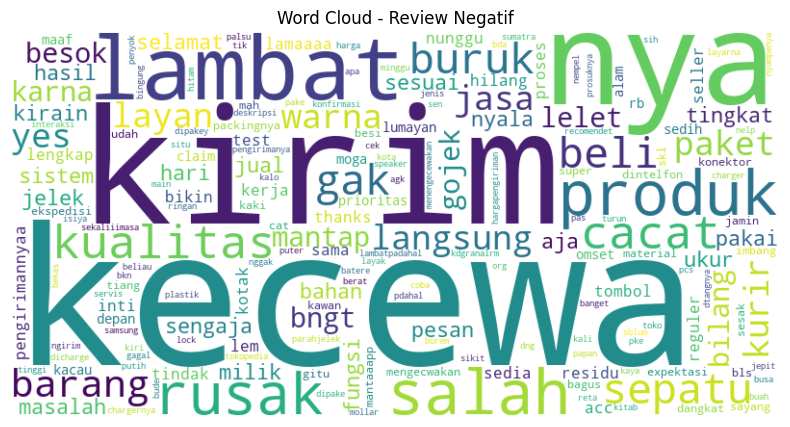

In [84]:
# Word Cloud untuk review negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Review Negatif')
plt.show()

Menampilkan Kata Paling Umum

In [89]:
def tokenize_text(text):
    return word_tokenize(text)
 
df['tokenized_text'] = df['cleaned_text'].apply(tokenize_text)
all_tokens = [token for sublist in df['tokenized_text'] for token in sublist]

fqdist = FreqDist(all_tokens)
most_common_words = fqdist.most_common(15)
most_common_words

[('barang', 2281),
 ('sesuai', 1455),
 ('cepat', 1106),
 ('bagus', 894),
 ('terima', 885),
 ('kirim', 697),
 ('kawan', 461),
 ('kasih', 442),
 ('respon', 434),
 ('pesan', 428),
 ('produk', 364),
 ('seller', 362),
 ('thanks', 335),
 ('deskripsi', 314),
 ('mantap', 313)]

C:\Users\Dicky Zulfikar\AppData\Local\Temp\ipykernel_20888\803265152.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencies, y=words, palette="viridis")


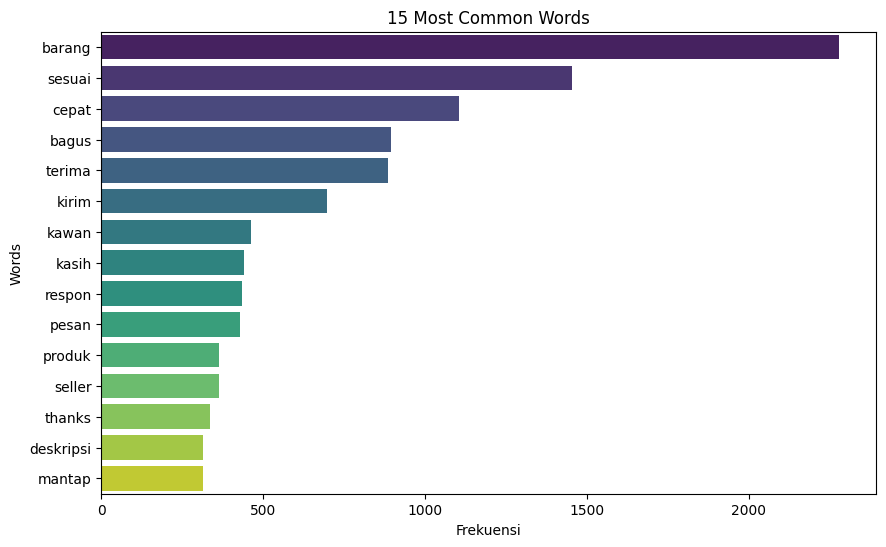

In [104]:
words = [word for word, freq in most_common_words]
frequencies = [freq for word, freq in most_common_words]

plt.figure(figsize=(10, 6))
sns.barplot(x=frequencies, y=words, palette="viridis")

plt.title("15 Most Common Words")
plt.xlabel("Frekuensi")
plt.ylabel("Words")
plt.show()

Menampilkan Frekuensi Kata Per Kategori

In [142]:
pemetaan_kata = {
    'Kualitas': ['bagus', 'mantap', 'sesuai', 'kualitas'],
    'Pengiriman': ['cepat', 'kirim', 'terima', 'lama'],
    'Seller/Respon': ['respon', 'seller', 'toko', 'ramah'],
    'Kesesuaian Produk': ['produk', 'sesuai', 'ukuran', 'pas'],
    'Deskripsi': ['deskripsi']
}

def get_word_frequencies(text_series):
    word_list = []
    for review in text_series:
        words = re.findall(r'\b\w+\b', review.lower())  
        word_list.extend(words)
    word_frequencies = Counter(word_list)
    return word_frequencies

categories = df['category'].unique() 
pemetaan_hasil = {kategori: {} for kategori in categories}

for category in categories:
    category_data = df[df['category'] == category] 
    frequencies = get_word_frequencies(category_data['cleaned_text'])
    
    for kata, freq in frequencies.most_common(15):
        for kategori, kata_kategori in pemetaan_kata.items():
            if kata in kata_kategori:
                if kategori not in pemetaan_hasil[category]:
                    pemetaan_hasil[category][kategori] = []
                pemetaan_hasil[category][kategori].append((kata, freq))

print("\nPemetaan Kata Berdasarkan Kategori:")
for category, kata_map in pemetaan_hasil.items():
    print(f"\n{category}:")
    for kategori, kata_freq in kata_map.items():
        print(f"  {kategori}: {', '.join(f'{kata} ({freq})' for kata, freq in kata_freq)}")



Pemetaan Kata Berdasarkan Kategori:

elektronik:
  Pengiriman: cepat (267), terima (208), kirim (160)
  Kualitas: sesuai (242), bagus (165), mantap (68)
  Kesesuaian Produk: sesuai (242), produk (69)
  Seller/Respon: respon (107), seller (92)

fashion:
  Kualitas: sesuai (367), bagus (229)
  Kesesuaian Produk: sesuai (367), produk (107)
  Pengiriman: cepat (256), kirim (163), terima (106)
  Seller/Respon: respon (101)
  Deskripsi: deskripsi (67)

olahraga:
  Kualitas: sesuai (285), bagus (189), kualitas (79), mantap (74)
  Kesesuaian Produk: sesuai (285), produk (56)
  Pengiriman: terima (220), cepat (196), kirim (104)
  Seller/Respon: respon (68), seller (61)

handphone:
  Kualitas: sesuai (271), bagus (154)
  Kesesuaian Produk: sesuai (271), produk (69)
  Pengiriman: cepat (162), terima (145), kirim (140)
  Seller/Respon: respon (70), seller (62)

pertukangan:
  Kualitas: sesuai (290), bagus (157), mantap (67)
  Kesesuaian Produk: sesuai (290), produk (63)
  Pengiriman: cepat (225),

Melakukan Ringkasan dari Pemetaan

In [144]:
def ringkasan_kategori(pemetaan_hasil):
    ringkasan = {}
    
    for category, kata_map in pemetaan_hasil.items():
        kualitas = set()
        pengiriman = set()
        seller = set()
        deskripsi = set()
        kesesuaian_produk = set() 
        
        if 'Kualitas' in kata_map:
            for kata, freq in kata_map['Kualitas']:
                kualitas.add(kata)
        if 'Pengiriman' in kata_map:
            pengiriman_list = [kata for kata, freq in kata_map['Pengiriman']]
            if 'cepat' in pengiriman_list:
                pengiriman = {'cepat'}
            else:
                pengiriman = set(pengiriman_list)
        if 'Seller/Respon' in kata_map:
            for kata, freq in kata_map['Seller/Respon']:
                seller.add(kata)
        if 'Deskripsi' in kata_map:
            deskripsi.add('Produk sesuai dengan deskripsi')
        if 'Kesesuaian Produk' in kata_map:
            kesesuaian_produk.add('Kesesuaian produk sesuai')
        
        kalimat_kualitas = f"Kualitas produk {category} " + ', '.join(kualitas) + "."
        kalimat_pengiriman = " Pengiriman " + ', '.join(pengiriman) + "."
        kalimat_seller = " Seller memberikan fast respon." if seller else ""
        kalimat_deskripsi = " " + ', '.join(deskripsi) + "." if deskripsi else ""
        kalimat_kesesuaian_produk = " " + ', '.join(kesesuaian_produk) + "." if kesesuaian_produk else ""

        ringkasan[category] = (
            kalimat_kualitas +
            kalimat_pengiriman +
            kalimat_seller +
            kalimat_deskripsi +
            kalimat_kesesuaian_produk
        )
    
    return ringkasan

ringkasan_hasil_singkat = ringkasan_kategori(pemetaan_hasil)
df_ringkasan_singkat = pd.DataFrame(list(ringkasan_hasil_singkat.items()), columns=['Kategori', 'Ringkasan'])
print(df_ringkasan_singkat.to_string(index=False))

   Kategori                                                                                                                                                     Ringkasan
 elektronik                                  Kualitas produk elektronik mantap, sesuai, bagus. Pengiriman cepat. Seller memberikan fast respon. Kesesuaian produk sesuai.
    fashion             Kualitas produk fashion sesuai, bagus. Pengiriman cepat. Seller memberikan fast respon. Produk sesuai dengan deskripsi. Kesesuaian produk sesuai.
   olahraga                          Kualitas produk olahraga mantap, kualitas, sesuai, bagus. Pengiriman cepat. Seller memberikan fast respon. Kesesuaian produk sesuai.
  handphone                                           Kualitas produk handphone sesuai, bagus. Pengiriman cepat. Seller memberikan fast respon. Kesesuaian produk sesuai.
pertukangan Kualitas produk pertukangan mantap, sesuai, bagus. Pengiriman cepat. Seller memberikan fast respon. Produk sesuai dengan deskripsi. Kesesu